In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/mnt/data4/haryoaw_workspace/projects/2021_2/speech/lc-fun-technical


In [2]:
from lc_fun_technical.pl_dataprocesser import SpeechCommandLitDataModule
from lc_fun_technical.modeling.lit_core import LitAudioClassifier
from transformers import Wav2Vec2Processor
from lc_fun_technical.factory import create_compose_wav2vec2
import torch
from tqdm import tqdm

/mnt/data3/shared_envs/ir-image/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


## Preparation

In [3]:
device = "cuda:0"

In [4]:
model_ckpt = LitAudioClassifier.load_from_checkpoint("outputs/model/wav2vec-pretrained/epoch=20-valid_loss=0.0713-valid_acc=0.98.ckpt")
processor = Wav2Vec2Processor.from_pretrained(
    model_ckpt.lit_args.pretrained_name
)
model_ckpt = model_ckpt.eval()
cps = create_compose_wav2vec2(wav2vec2_processer=processor, sample_rate=16000)
lit_module= SpeechCommandLitDataModule("data/raw/", cps, batch_size_train=32, batch_size_val=32, batch_size_test=32, n_workers=4)
lit_module.setup(stage="test")
test_dl = lit_module.test_dataloader()
model_ckpt = model_ckpt.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'wav2vec2.masked_spec_embed', 'classifier.dense.bias']
You should probably TRAIN this model on a

In [8]:
idx_to_label = {j: i for j, i in enumerate(lit_module.speech_test_dataset.LABELS)}
label_str = lit_module.speech_test_dataset.LABELS.copy()
label_str.pop(-2)  # remove '_silence_'

'_silence_'

## Prediction

In [9]:
gts = []  # ground truth
preds = []  # Prediction

with torch.no_grad():
    for test_batch in tqdm(test_dl):
        inp, gt_label = test_batch
        logits = model_ckpt(inp.to(device))
        pred_labels = logits.argmax(dim=1)
        preds += pred_labels.cpu().numpy().tolist()
        gts += gt_label.numpy().tolist()

100%|██████████| 344/344 [00:11<00:00, 29.49it/s]


## Plotting

In [10]:
gts_str = [idx_to_label[x] for x in gts]
preds_str = [idx_to_label[x] for x in preds]

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
print(classification_report(gts_str, preds_str, digits=4))

              precision    recall  f1-score   support

   _unknown_     0.9959    0.9853    0.9906      6931
        down     0.9685    0.9852    0.9768       406
          go     0.9629    0.9677    0.9653       402
        left     0.9421    0.9879    0.9645       412
          no     0.9685    0.9877    0.9780       405
         off     0.9730    0.9851    0.9790       402
          on     0.9723    0.9747    0.9735       396
       right     0.9630    0.9848    0.9738       396
        stop     0.9808    0.9951    0.9879       411
          up     0.9269    0.9553    0.9409       425
         yes     0.9882    0.9952    0.9917       419

    accuracy                         0.9840     11005
   macro avg     0.9675    0.9822    0.9747     11005
weighted avg     0.9843    0.9840    0.9841     11005



In [13]:
cf_matrix = confusion_matrix(gts_str, preds_str, labels=label_str)

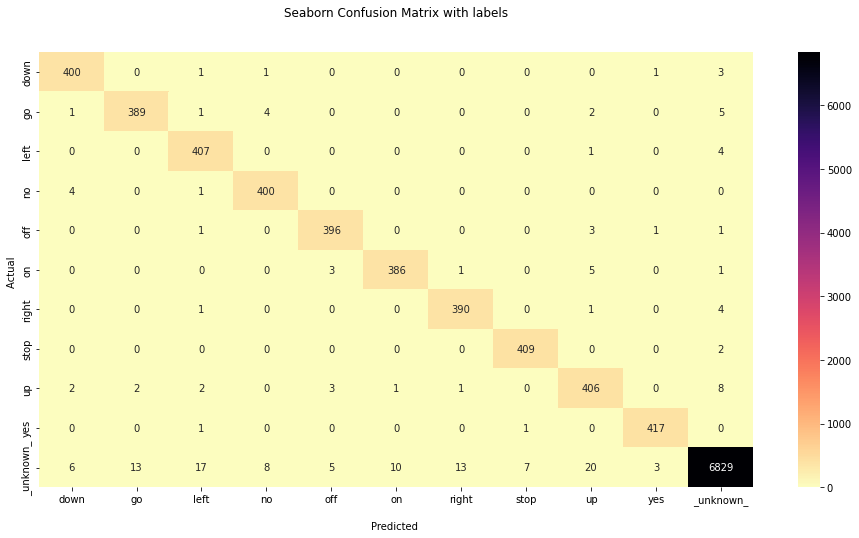

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='magma_r', fmt="g")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted ')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_str)
ax.yaxis.set_ticklabels(label_str)

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
import pandas as pd

In [18]:
df = pd.DataFrame(dict(pred=preds_str, gts=gts_str))

In [24]:
idx = df[(df.pred == 'up') & (df.gts == '_unknown_')].index

In [21]:
df[(df.pred == 'up') & (df.gts == '_unknown_')]

pred        gts
653     up  _unknown_
913     up  _unknown_
1115    up  _unknown_
1188    up  _unknown_
1447    up  _unknown_
1635    up  _unknown_
1645    up  _unknown_
1689    up  _unknown_
2469    up  _unknown_
2476    up  _unknown_
5108    up  _unknown_
5421    up  _unknown_
5683    up  _unknown_
6011    up  _unknown_
7569    up  _unknown_
7888    up  _unknown_
7907    up  _unknown_
8593    up  _unknown_
10136   up  _unknown_
10796   up  _unknown_

## Label predicted up but actually _unknown_

('data/raw/SpeechCommands/speech_commands_v0.02/eight/8ea6dec6_nohash_0.wav', 'eight')


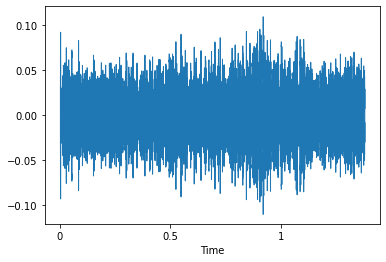

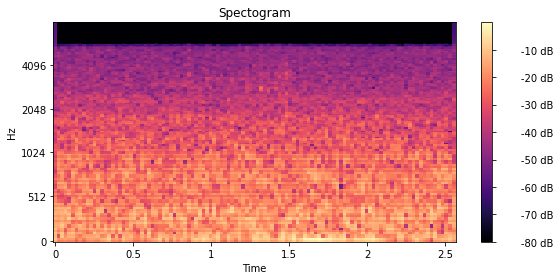

('data/raw/SpeechCommands/speech_commands_v0.02/cat/8ea6dec6_nohash_0.wav', 'cat')


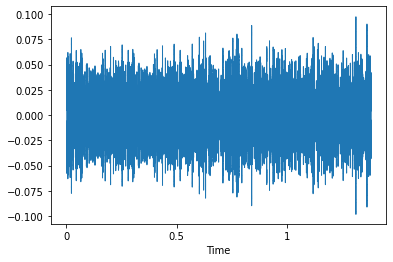

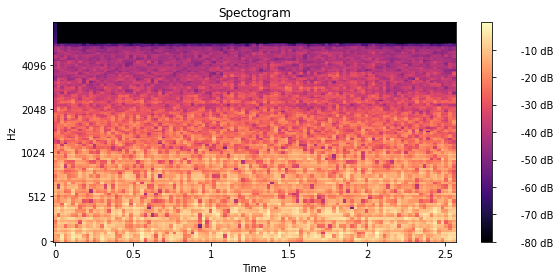

('data/raw/SpeechCommands/speech_commands_v0.02/tree/8ea6dec6_nohash_0.wav', 'tree')


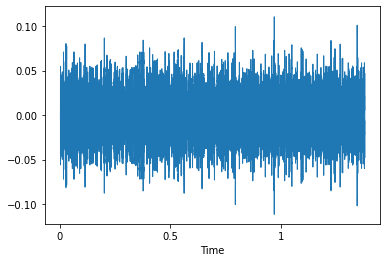

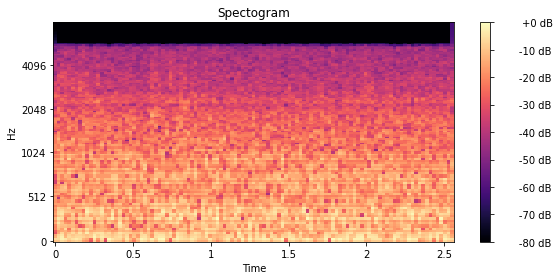

('data/raw/SpeechCommands/speech_commands_v0.02/tree/475b61f1_nohash_0.wav', 'tree')


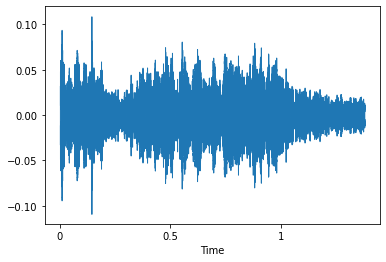

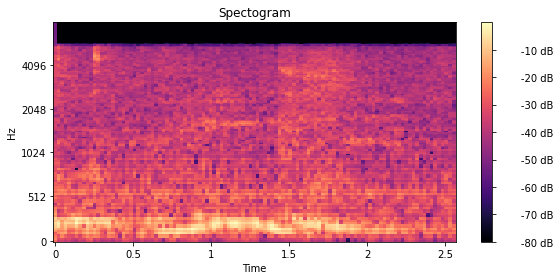

('data/raw/SpeechCommands/speech_commands_v0.02/learn/8ea6dec6_nohash_0.wav', 'learn')


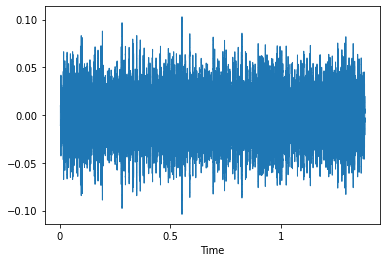

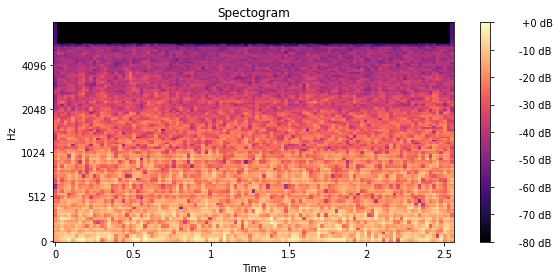

('data/raw/SpeechCommands/speech_commands_v0.02/bed/8ea6dec6_nohash_1.wav', 'bed')


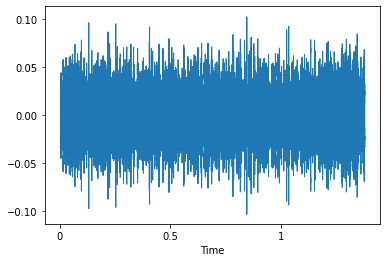

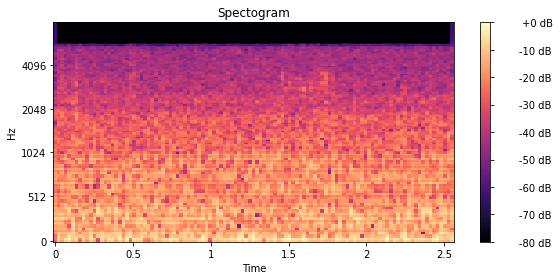

('data/raw/SpeechCommands/speech_commands_v0.02/bed/8ea6dec6_nohash_0.wav', 'bed')


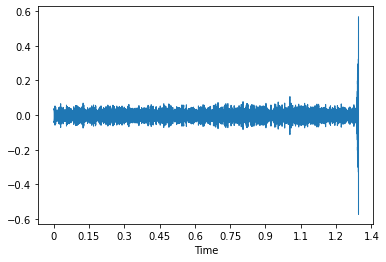

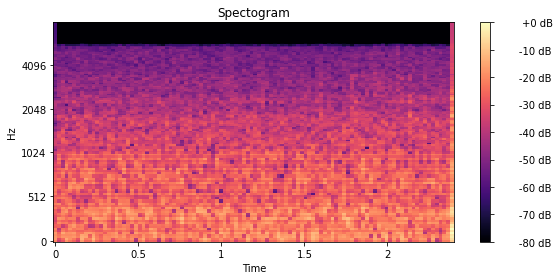

('data/raw/SpeechCommands/speech_commands_v0.02/bed/2005ca25_nohash_0.wav', 'bed')


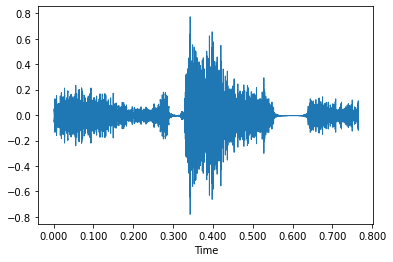

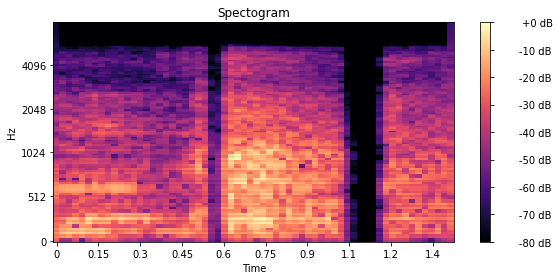

('data/raw/SpeechCommands/speech_commands_v0.02/dog/8ea6dec6_nohash_1.wav', 'dog')


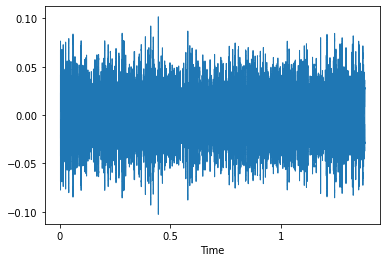

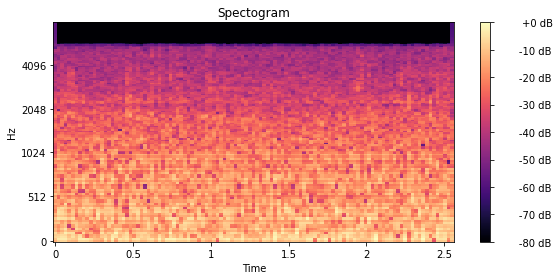

('data/raw/SpeechCommands/speech_commands_v0.02/dog/8ea6dec6_nohash_0.wav', 'dog')


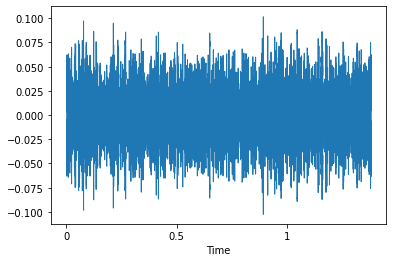

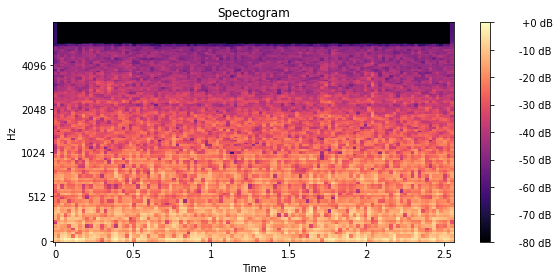

('data/raw/SpeechCommands/speech_commands_v0.02/sheila/8ea6dec6_nohash_0.wav', 'sheila')


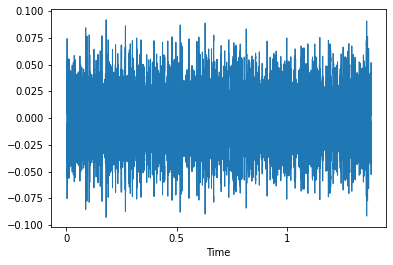

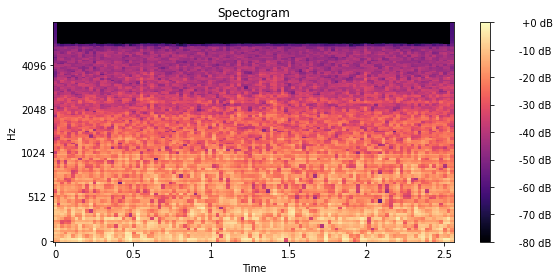

('data/raw/SpeechCommands/speech_commands_v0.02/one/8ea6dec6_nohash_0.wav', 'one')


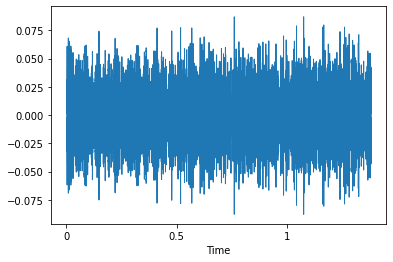

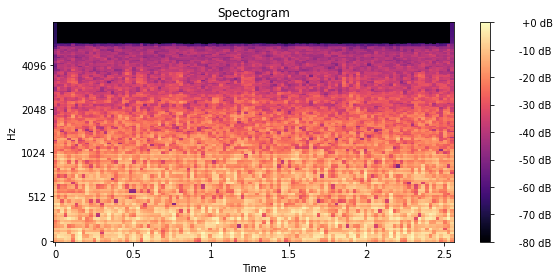

('data/raw/SpeechCommands/speech_commands_v0.02/bird/8ea6dec6_nohash_1.wav', 'bird')


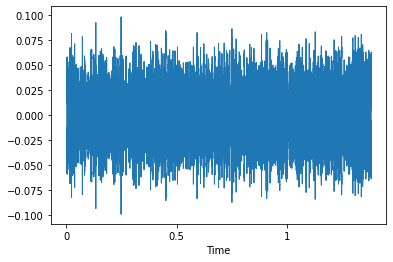

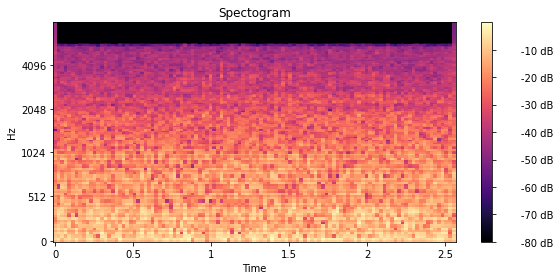

('data/raw/SpeechCommands/speech_commands_v0.02/zero/8ea6dec6_nohash_0.wav', 'zero')


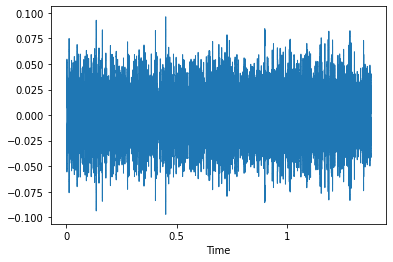

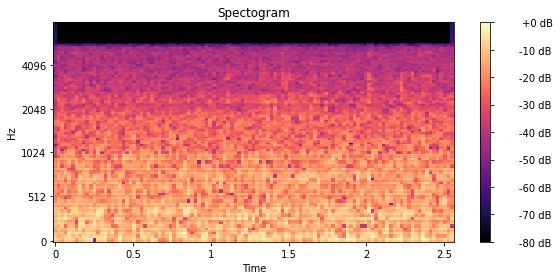

('data/raw/SpeechCommands/speech_commands_v0.02/two/a9f54d8d_nohash_0.wav', 'two')


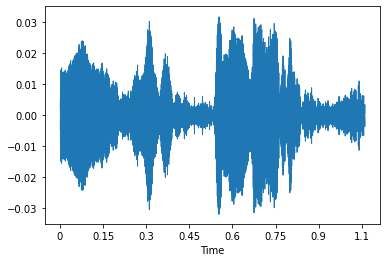

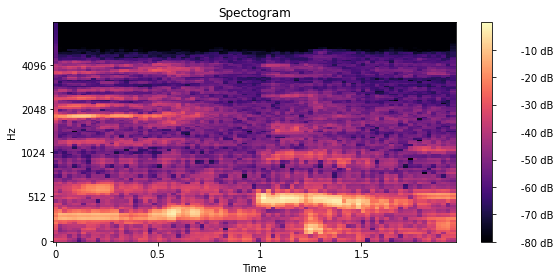

('data/raw/SpeechCommands/speech_commands_v0.02/house/3659fc1c_nohash_0.wav', 'house')


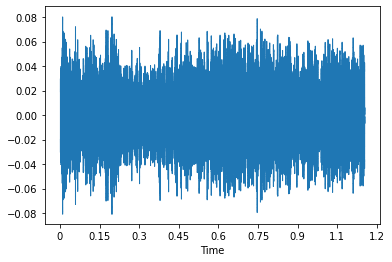

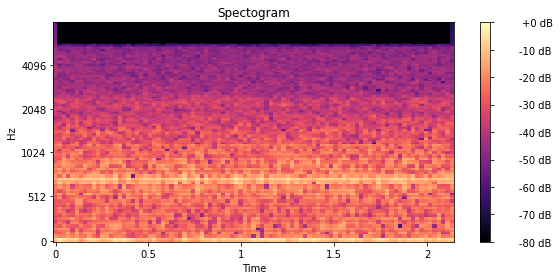

('data/raw/SpeechCommands/speech_commands_v0.02/house/8ea6dec6_nohash_0.wav', 'house')


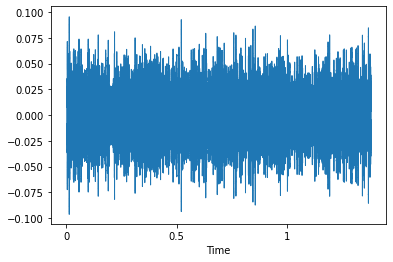

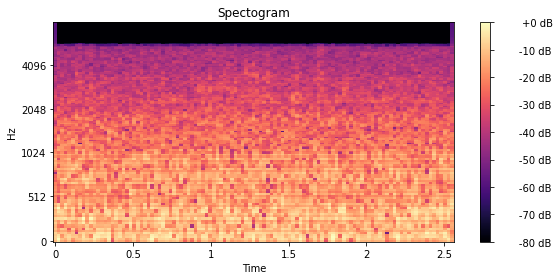

('data/raw/SpeechCommands/speech_commands_v0.02/six/3659fc1c_nohash_0.wav', 'six')


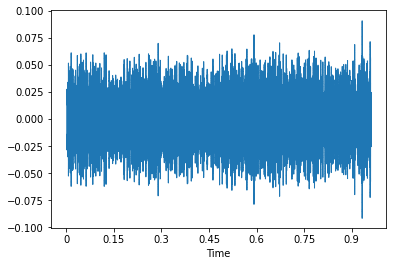

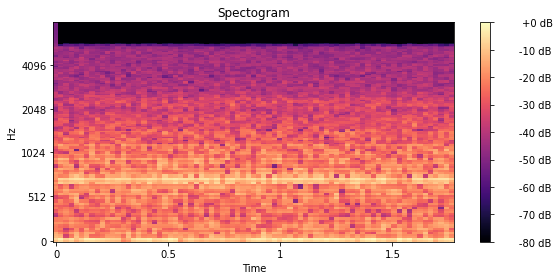

('data/raw/SpeechCommands/speech_commands_v0.02/forward/8ea6dec6_nohash_0.wav', 'forward')


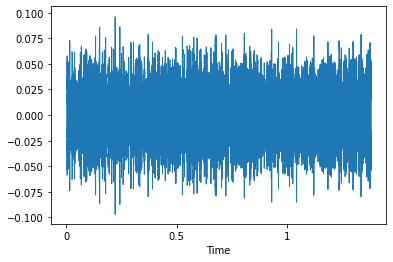

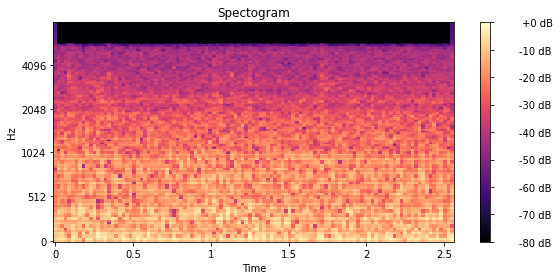

('data/raw/SpeechCommands/speech_commands_v0.02/four/faf2576f_nohash_0.wav', 'four')


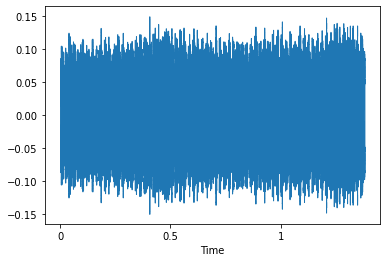

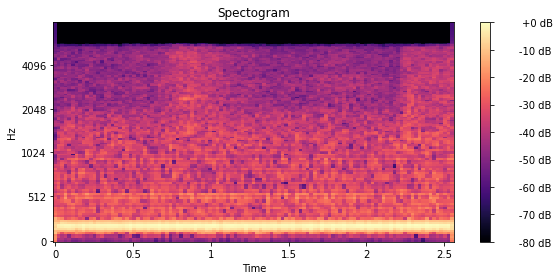

In [36]:
for i in idx:
    audio_data = lit_module.speech_test_dataset.data[i]
    print(audio_data)
    notebook_visualize_audio_individual(audio_data[0])

In [28]:
from lc_fun_technical.inference import notebook_visualize_audio_individual

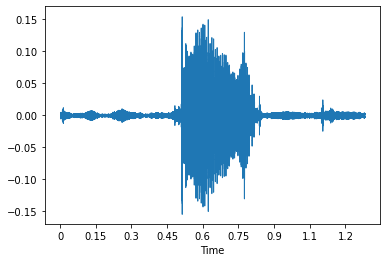

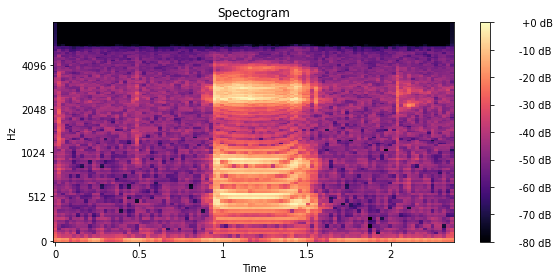